This tutorial demonstrates the perturbational aspect of the model on some of the original mapseq data...

In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_lf_hf_pair_data
from mcspace.utils import get_device, pickle_load, pickle_save, get_summary_stats
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import mcspace.visualization as vis

In [3]:
torch.manual_seed(0)
np.random.seed(0)

# Paths

In [4]:
rootpath = Path("../")
datapath = rootpath / "data"

# Load the dataset

In [5]:
min_abundance=0.005
min_reads=100
max_reads=10000

In [6]:
reads, taxonomy = get_lf_hf_pair_data(min_abundance=min_abundance, min_reads=min_reads, max_reads=max_reads, datapath=datapath)

In [7]:
reads.keys()

dict_keys([0, 1])

In [8]:
reads[0].keys()

dict_keys(['s1'])

In [9]:
reads[0]['s1'].shape

(483, 54)

In [10]:
reads[1]['s1'].shape

(1366, 54)

# Setup model

In [11]:
device = get_device()

In [12]:
data = get_data(reads, device)

In [13]:
# TODO: describe options...
num_otus = taxonomy.shape[0]
num_assemblages = 50
times = list(reads.keys())
subjects = list(reads[times[0]].keys())
perturbed_times = [0, 1] #! check this and make more 'user friendly...'
perturbation_prior = 0.5/num_assemblages
sparsity_prior = 0.5/num_assemblages

In [14]:
# automatically set prior scale?
num_reads = 0
for t in times:
    for s in subjects:
        num_reads += reads[t][s].sum()
sparsity_prior_power = 0.1*num_reads #! check scaling with larger datasets?...

process_var_prior = None
add_process_var=False

### instantiate model

In [15]:
model = MCSPACE(num_assemblages,
                num_otus,
                times,
                subjects,
                perturbed_times,
                perturbation_prior,
                sparsity_prior,
                sparsity_prior_power,
                process_var_prior,
                device,
                add_process_var)

In [16]:
model.to(device)

MCSPACE(
  (beta_params): AssemblageProportions(
    (sparsity_params): SparsityIndicatorPowerScale()
    (perturbation_indicators): PerturbationIndicators()
    (perturbation_magnitude): PerturbationMagnitude(
      (q_encode): Sequential(
        (0): Linear(in_features=54, out_features=10, bias=True)
        (1): Softplus(beta=1, threshold=20)
        (2): Linear(in_features=10, out_features=10, bias=True)
        (3): Softplus(beta=1, threshold=20)
      )
      (q_mu_params): Linear(in_features=10, out_features=50, bias=True)
      (q_var_params): Linear(in_features=10, out_features=50, bias=True)
    )
    (latent_distrib): LatentTimeSeriesMixtureWeights(
      (q_encode): Sequential(
        (0): Linear(in_features=54, out_features=50, bias=True)
        (1): Softplus(beta=1, threshold=20)
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): Softplus(beta=1, threshold=20)
      )
      (q_mu_params): Linear(in_features=50, out_features=50, bias=True)
    

In [17]:
num_epochs = 5000

# Train model

depending on your device/machine, this might take a few minutes

In [18]:
elbos = train_model(model, data, num_epochs)


epoch 0
ELBO =  tensor(28151924., device='cuda:0', grad_fn=<NegBackward0>)

epoch 100
ELBO =  tensor(24367542., device='cuda:0', grad_fn=<NegBackward0>)

epoch 200
ELBO =  tensor(21206552., device='cuda:0', grad_fn=<NegBackward0>)

epoch 300
ELBO =  tensor(18960114., device='cuda:0', grad_fn=<NegBackward0>)

epoch 400
ELBO =  tensor(17433286., device='cuda:0', grad_fn=<NegBackward0>)

epoch 500
ELBO =  tensor(16350252., device='cuda:0', grad_fn=<NegBackward0>)

epoch 600
ELBO =  tensor(15633873., device='cuda:0', grad_fn=<NegBackward0>)

epoch 700
ELBO =  tensor(15126075., device='cuda:0', grad_fn=<NegBackward0>)

epoch 800
ELBO =  tensor(14830059., device='cuda:0', grad_fn=<NegBackward0>)

epoch 900
ELBO =  tensor(14661399., device='cuda:0', grad_fn=<NegBackward0>)

epoch 1000
ELBO =  tensor(14547200., device='cuda:0', grad_fn=<NegBackward0>)

epoch 1100
ELBO =  tensor(14471294., device='cuda:0', grad_fn=<NegBackward0>)

epoch 1200
ELBO =  tensor(14412332., device='cuda:0', grad_fn=<

# Plot the loss over training epochs

Text(0, 0.5, 'ELBO loss')

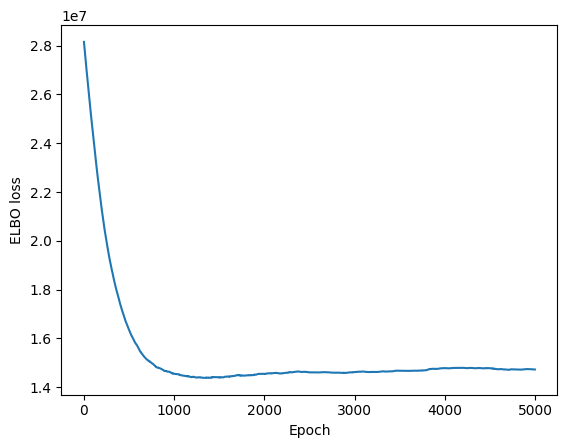

In [19]:
fig, ax = plt.subplots()
ax.plot(elbos)
ax.set_xlabel("Epoch")
ax.set_ylabel("ELBO loss")

# Visualize the results

In [20]:
pert_bf, beta, theta = get_summary_stats(model, data)

In [21]:
otu_order, assemblage_order = vis.get_clustered_otu_assemblage_ordering(theta)

In [22]:
labels = ["Low fat", "High fat"]

(<Figure size 850x1320 with 4 Axes>,
 <Axes: >,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x28c3ff81e40>)

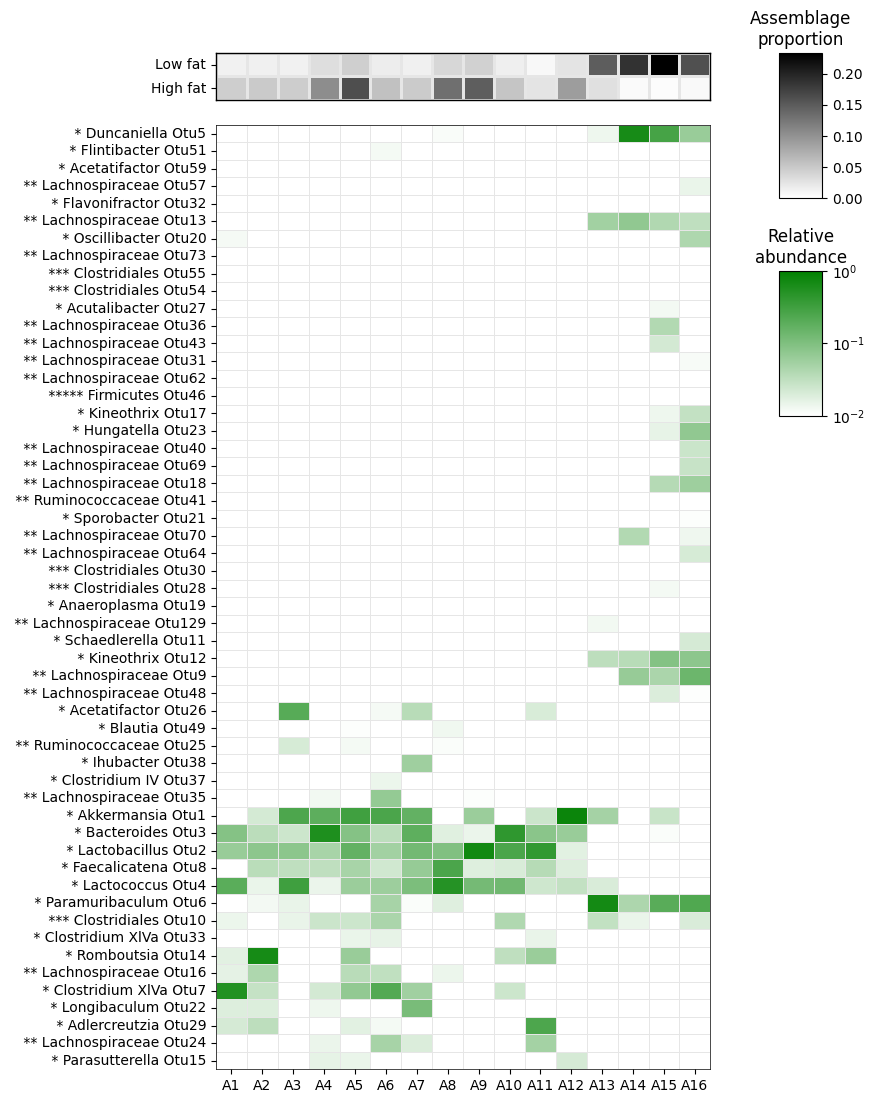

In [23]:
vis.render_proportions_and_assemblages(beta, theta, taxonomy, otu_order, assemblage_order, ylabels=labels)

In [24]:
betadiff = beta[:,1,:] - beta[:,0,:]

C:\Users\Gary\anaconda3\envs\mcspace3\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Gary\anaconda3\envs\mcspace3\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
C:\Users\Gary\anaconda3\envs\mcspace3\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Gary\anaconda3\envs\mcspace3\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


(<Figure size 850x1320 with 6 Axes>,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: title={'center': 'Perturbation\nBayes Factor'}>,
 <matplotlib.colorbar.Colorbar at 0x28bf553d990>)

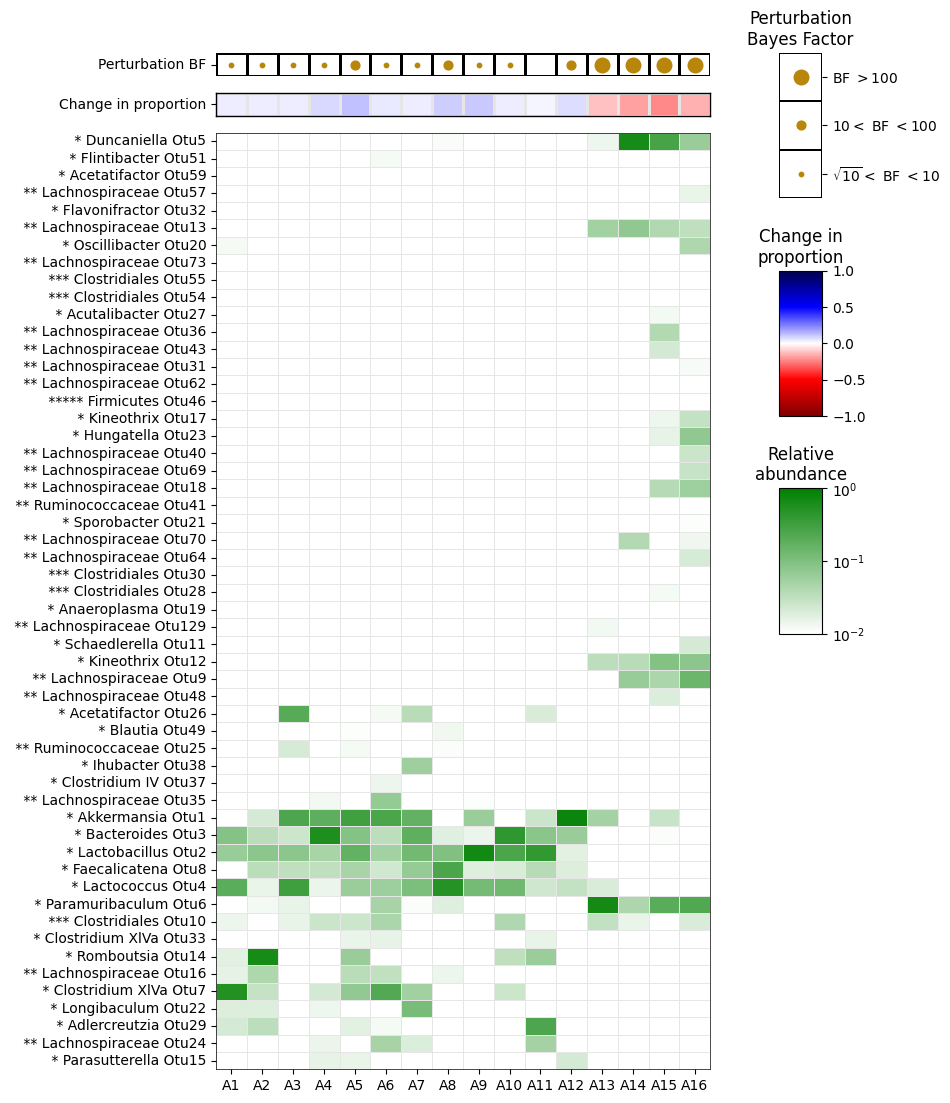

In [25]:
vis.render_perturbation_effect_and_assemblages(pert_bf, betadiff, theta, taxonomy, otu_order, assemblage_order)